# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('BipedalWalker-v2')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(4,), Box(24,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(4, 24)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

### 3. Instantiate DDPG Agent

In [8]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [18]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=3000

n_steps=10000
n_learn=10
learn_every=20

R_goal=0 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot

dlosses, glosses, dlosses_Q, dlosses_S = [], [], [], []

In [19]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

In [20]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    dlosses_, glosses_, dlosses_Q_, dlosses_S_ = [], [], [], []
    
    for i_step in range(n_steps):
    #while True:
        
        a = agent.act(np.reshape(s, [1, -1])) # a=[-1, 1]
        #a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        s2, r, done, _ = env.step(np.reshape(a, [-1]))
        #print(s2.shape, r, done)


        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over states to next time step

        dlosses__, glosses__, dlosses_Q__, dlosses_S__ = [], [], [], []
        if i_step%learn_every == 0:
            for _ in range(n_learn):
                dloss, gloss, dloss_Q, dloss_S = agent.start_learn()
                dlosses__.append(dloss)
                glosses__.append(gloss)
                dlosses_Q__.append(dloss_Q)
                dlosses_S__.append(dloss_S)
            dlosses_.append(np.mean(dlosses__))
            glosses_.append(np.mean(glosses__))
            dlosses_Q_.append(np.mean(dlosses_Q__))
            dlosses_S_.append(np.mean(dlosses_S__))
            
        # print(len(agent.memory))
        # agent.start_learn()

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    
    dlosses.append(np.mean(dlosses_))
    glosses.append(np.mean(glosses_))
    dlosses_Q.append(np.mean(dlosses_Q_))
    dlosses_S.append(np.mean(dlosses_S_))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}\tDloss: {:.2f}\tDlossQ: {:.2f}\tDlossS: {:.2f}'.format(
            i_episode+1, np.mean(Rs_deque), np.mean(glosses_), np.mean(dlosses_), np.mean(dlosses_Q_), np.mean(dlosses_S_)))
    
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-bipedal.pth')
        torch.save(agent.d.state_dict(), 'd-bipedal.pth')
        break

Episode 1	Total Average Score: -25.27	Gloss: -0.05	Dloss: 51.41	DlossQ: 51.29	DlossS: 0.12
Episode 2	Total Average Score: -73.95	Gloss: -0.05	Dloss: 48.82	DlossQ: 48.70	DlossS: 0.12
Episode 3	Total Average Score: -81.31	Gloss: -0.05	Dloss: 44.33	DlossQ: 44.20	DlossS: 0.12
Episode 4	Total Average Score: -85.20	Gloss: -0.05	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 5	Total Average Score: -87.42	Gloss: -0.05	Dloss: 51.76	DlossQ: 51.63	DlossS: 0.12
Episode 6	Total Average Score: -88.84	Gloss: -0.05	Dloss: 46.28	DlossQ: 46.16	DlossS: 0.12
Episode 7	Total Average Score: -89.97	Gloss: -0.05	Dloss: 52.34	DlossQ: 52.22	DlossS: 0.12
Episode 8	Total Average Score: -90.68	Gloss: -0.05	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 9	Total Average Score: -93.47	Gloss: -0.05	Dloss: 51.95	DlossQ: 51.83	DlossS: 0.12
Episode 10	Total Average Score: -93.74	Gloss: -0.05	Dloss: 52.15	DlossQ: 52.02	DlossS: 0.12
Episode 11	Total Average Score: -94.02	Gloss: -0.05	Dloss: 53.09	DlossQ: 52.97	DlossS: 0.

Episode 91	Total Average Score: -97.64	Gloss: -0.04	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 92	Total Average Score: -97.62	Gloss: -0.04	Dloss: 48.62	DlossQ: 48.50	DlossS: 0.12
Episode 93	Total Average Score: -97.62	Gloss: -0.04	Dloss: 47.30	DlossQ: 47.18	DlossS: 0.12
Episode 94	Total Average Score: -97.61	Gloss: -0.04	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 95	Total Average Score: -97.65	Gloss: -0.04	Dloss: 51.11	DlossQ: 50.99	DlossS: 0.12
Episode 96	Total Average Score: -97.65	Gloss: -0.04	Dloss: 43.64	DlossQ: 43.52	DlossS: 0.12
Episode 97	Total Average Score: -97.63	Gloss: -0.04	Dloss: 52.93	DlossQ: 52.80	DlossS: 0.12
Episode 98	Total Average Score: -97.62	Gloss: -0.04	Dloss: 48.20	DlossQ: 48.08	DlossS: 0.12
Episode 99	Total Average Score: -97.62	Gloss: -0.04	Dloss: 52.76	DlossQ: 52.64	DlossS: 0.12
Episode 100	Total Average Score: -97.64	Gloss: -0.04	Dloss: 48.28	DlossQ: 48.16	DlossS: 0.12
Episode 101	Total Average Score: -98.39	Gloss: -0.04	Dloss: 45.76	DlossQ: 45.64

Episode 180	Total Average Score: -99.01	Gloss: -0.04	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 181	Total Average Score: -99.00	Gloss: -0.04	Dloss: 54.01	DlossQ: 53.89	DlossS: 0.12
Episode 182	Total Average Score: -99.02	Gloss: -0.04	Dloss: 50.38	DlossQ: 50.26	DlossS: 0.12
Episode 183	Total Average Score: -99.47	Gloss: -0.04	Dloss: 54.63	DlossQ: 54.51	DlossS: 0.12
Episode 184	Total Average Score: -99.49	Gloss: -0.04	Dloss: 56.35	DlossQ: 56.22	DlossS: 0.12
Episode 185	Total Average Score: -99.51	Gloss: -0.04	Dloss: 57.42	DlossQ: 57.30	DlossS: 0.12
Episode 186	Total Average Score: -99.55	Gloss: -0.04	Dloss: 51.75	DlossQ: 51.63	DlossS: 0.12
Episode 187	Total Average Score: -99.64	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 188	Total Average Score: -99.63	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 189	Total Average Score: -99.65	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 190	Total Average Score: -99.67	Gloss: -0.04	Dloss: 51.75	Dlos

Episode 268	Total Average Score: -103.09	Gloss: -0.04	Dloss: 55.12	DlossQ: 55.00	DlossS: 0.12
Episode 269	Total Average Score: -103.15	Gloss: -0.04	Dloss: 55.85	DlossQ: 55.74	DlossS: 0.12
Episode 270	Total Average Score: -103.01	Gloss: -0.04	Dloss: 49.01	DlossQ: 48.89	DlossS: 0.12
Episode 271	Total Average Score: -103.01	Gloss: -0.04	Dloss: 58.01	DlossQ: 57.89	DlossS: 0.12
Episode 272	Total Average Score: -103.00	Gloss: -0.04	Dloss: 48.82	DlossQ: 48.70	DlossS: 0.12
Episode 273	Total Average Score: -103.09	Gloss: -0.04	Dloss: 55.86	DlossQ: 55.74	DlossS: 0.12
Episode 274	Total Average Score: -103.10	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 275	Total Average Score: -103.23	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 276	Total Average Score: -103.20	Gloss: -0.04	Dloss: 48.43	DlossQ: 48.31	DlossS: 0.12
Episode 277	Total Average Score: -103.19	Gloss: -0.04	Dloss: 54.63	DlossQ: 54.51	DlossS: 0.12
Episode 278	Total Average Score: -103.22	Gloss: -0.04	Dloss:

Episode 356	Total Average Score: -103.38	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 357	Total Average Score: -103.24	Gloss: -0.04	Dloss: 57.08	DlossQ: 56.96	DlossS: 0.12
Episode 358	Total Average Score: -103.10	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 359	Total Average Score: -103.12	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 360	Total Average Score: -103.12	Gloss: -0.04	Dloss: 56.83	DlossQ: 56.71	DlossS: 0.12
Episode 361	Total Average Score: -103.11	Gloss: -0.04	Dloss: 59.52	DlossQ: 59.40	DlossS: 0.12
Episode 362	Total Average Score: -103.24	Gloss: -0.04	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 363	Total Average Score: -103.24	Gloss: -0.04	Dloss: 56.84	DlossQ: 56.71	DlossS: 0.12
Episode 364	Total Average Score: -103.26	Gloss: -0.04	Dloss: 60.74	DlossQ: 60.62	DlossS: 0.12
Episode 365	Total Average Score: -103.14	Gloss: -0.04	Dloss: 53.17	DlossQ: 53.05	DlossS: 0.12
Episode 366	Total Average Score: -103.19	Gloss: -0.04	Dloss:

Episode 444	Total Average Score: -104.99	Gloss: -0.04	Dloss: 60.01	DlossQ: 59.89	DlossS: 0.12
Episode 445	Total Average Score: -105.00	Gloss: -0.04	Dloss: 63.09	DlossQ: 62.97	DlossS: 0.12
Episode 446	Total Average Score: -105.02	Gloss: -0.04	Dloss: 57.33	DlossQ: 57.20	DlossS: 0.12
Episode 447	Total Average Score: -105.04	Gloss: -0.04	Dloss: 53.71	DlossQ: 53.59	DlossS: 0.12
Episode 448	Total Average Score: -105.14	Gloss: -0.04	Dloss: 62.21	DlossQ: 62.09	DlossS: 0.12
Episode 449	Total Average Score: -105.13	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 450	Total Average Score: -105.14	Gloss: -0.04	Dloss: 62.11	DlossQ: 61.99	DlossS: 0.12
Episode 451	Total Average Score: -105.30	Gloss: -0.04	Dloss: 57.25	DlossQ: 57.13	DlossS: 0.12
Episode 452	Total Average Score: -105.42	Gloss: -0.04	Dloss: 56.10	DlossQ: 55.98	DlossS: 0.12
Episode 453	Total Average Score: -105.42	Gloss: -0.04	Dloss: 63.44	DlossQ: 63.31	DlossS: 0.12
Episode 454	Total Average Score: -105.55	Gloss: -0.04	Dloss:

Episode 532	Total Average Score: -106.12	Gloss: -0.04	Dloss: 52.19	DlossQ: 52.07	DlossS: 0.12
Episode 533	Total Average Score: -106.13	Gloss: -0.04	Dloss: 67.20	DlossQ: 67.07	DlossS: 0.12
Episode 534	Total Average Score: -106.27	Gloss: -0.04	Dloss: 62.21	DlossQ: 62.09	DlossS: 0.12
Episode 535	Total Average Score: -106.34	Gloss: -0.04	Dloss: 61.23	DlossQ: 61.11	DlossS: 0.12
Episode 536	Total Average Score: -106.34	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 537	Total Average Score: -106.36	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 538	Total Average Score: -106.37	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 539	Total Average Score: -106.37	Gloss: -0.04	Dloss: 60.75	DlossQ: 60.62	DlossS: 0.12
Episode 540	Total Average Score: -106.47	Gloss: -0.04	Dloss: 57.57	DlossQ: 57.45	DlossS: 0.12
Episode 541	Total Average Score: -106.47	Gloss: -0.04	Dloss: 64.66	DlossQ: 64.53	DlossS: 0.12
Episode 542	Total Average Score: -106.57	Gloss: -0.04	Dloss:

Episode 620	Total Average Score: -105.78	Gloss: -0.04	Dloss: 54.07	DlossQ: 53.95	DlossS: 0.12
Episode 621	Total Average Score: -105.79	Gloss: -0.04	Dloss: 60.94	DlossQ: 60.82	DlossS: 0.12
Episode 622	Total Average Score: -105.64	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 623	Total Average Score: -105.50	Gloss: -0.04	Dloss: 62.95	DlossQ: 62.82	DlossS: 0.12
Episode 624	Total Average Score: -105.62	Gloss: -0.04	Dloss: 65.82	DlossQ: 65.71	DlossS: 0.12
Episode 625	Total Average Score: -105.60	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 626	Total Average Score: -105.73	Gloss: -0.04	Dloss: 63.51	DlossQ: 63.39	DlossS: 0.12
Episode 627	Total Average Score: -105.72	Gloss: -0.04	Dloss: 62.05	DlossQ: 61.93	DlossS: 0.12
Episode 628	Total Average Score: -105.59	Gloss: -0.04	Dloss: 69.78	DlossQ: 69.66	DlossS: 0.12
Episode 629	Total Average Score: -105.47	Gloss: -0.04	Dloss: 60.01	DlossQ: 59.89	DlossS: 0.12
Episode 630	Total Average Score: -105.34	Gloss: -0.04	Dloss:

Episode 708	Total Average Score: -101.58	Gloss: -0.04	Dloss: 63.92	DlossQ: 63.80	DlossS: 0.12
Episode 709	Total Average Score: -101.58	Gloss: -0.04	Dloss: 64.41	DlossQ: 64.29	DlossS: 0.12
Episode 710	Total Average Score: -101.58	Gloss: -0.04	Dloss: 64.27	DlossQ: 64.14	DlossS: 0.12
Episode 711	Total Average Score: -101.61	Gloss: -0.04	Dloss: 67.59	DlossQ: 67.47	DlossS: 0.12
Episode 712	Total Average Score: -101.73	Gloss: -0.04	Dloss: 63.49	DlossQ: 63.36	DlossS: 0.13
Episode 713	Total Average Score: -101.60	Gloss: -0.04	Dloss: 63.19	DlossQ: 63.07	DlossS: 0.12
Episode 714	Total Average Score: -101.74	Gloss: -0.04	Dloss: 59.93	DlossQ: 59.81	DlossS: 0.12
Episode 715	Total Average Score: -101.62	Gloss: -0.04	Dloss: 61.14	DlossQ: 61.02	DlossS: 0.12
Episode 716	Total Average Score: -101.63	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 717	Total Average Score: -101.50	Gloss: -0.04	Dloss: 60.75	DlossQ: 60.63	DlossS: 0.12
Episode 718	Total Average Score: -101.61	Gloss: -0.04	Dloss:

Episode 796	Total Average Score: -106.06	Gloss: -0.04	Dloss: 63.68	DlossQ: 63.56	DlossS: 0.12
Episode 797	Total Average Score: -106.11	Gloss: -0.04	Dloss: 67.83	DlossQ: 67.71	DlossS: 0.12
Episode 798	Total Average Score: -106.04	Gloss: -0.04	Dloss: 62.46	DlossQ: 62.34	DlossS: 0.12
Episode 799	Total Average Score: -106.04	Gloss: -0.04	Dloss: 72.23	DlossQ: 72.11	DlossS: 0.12
Episode 800	Total Average Score: -106.04	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 801	Total Average Score: -106.20	Gloss: -0.04	Dloss: 65.14	DlossQ: 65.02	DlossS: 0.12
Episode 802	Total Average Score: -106.29	Gloss: -0.04	Dloss: 68.24	DlossQ: 68.12	DlossS: 0.12
Episode 803	Total Average Score: -106.22	Gloss: -0.04	Dloss: 67.71	DlossQ: 67.59	DlossS: 0.12
Episode 804	Total Average Score: -106.29	Gloss: -0.04	Dloss: 62.42	DlossQ: 62.30	DlossS: 0.12
Episode 805	Total Average Score: -106.28	Gloss: -0.04	Dloss: 67.59	DlossQ: 67.47	DlossS: 0.12
Episode 806	Total Average Score: -106.29	Gloss: -0.04	Dloss:

Episode 884	Total Average Score: -107.51	Gloss: -0.04	Dloss: 60.50	DlossQ: 60.38	DlossS: 0.12
Episode 885	Total Average Score: -107.42	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 886	Total Average Score: -107.41	Gloss: -0.04	Dloss: 66.61	DlossQ: 66.49	DlossS: 0.12
Episode 887	Total Average Score: -107.19	Gloss: -0.04	Dloss: 65.63	DlossQ: 65.51	DlossS: 0.12
Episode 888	Total Average Score: -107.33	Gloss: -0.04	Dloss: 67.00	DlossQ: 66.88	DlossS: 0.12
Episode 889	Total Average Score: -107.31	Gloss: -0.04	Dloss: 67.20	DlossQ: 67.07	DlossS: 0.12
Episode 890	Total Average Score: -107.36	Gloss: -0.04	Dloss: 67.37	DlossQ: 67.25	DlossS: 0.12
Episode 891	Total Average Score: -107.41	Gloss: -0.04	Dloss: 67.31	DlossQ: 67.19	DlossS: 0.12
Episode 892	Total Average Score: -107.24	Gloss: -0.04	Dloss: 69.44	DlossQ: 69.31	DlossS: 0.12
Episode 893	Total Average Score: -107.16	Gloss: -0.04	Dloss: 68.76	DlossQ: 68.64	DlossS: 0.12
Episode 894	Total Average Score: -107.17	Gloss: -0.04	Dloss:

Episode 972	Total Average Score: -106.80	Gloss: -0.04	Dloss: 68.03	DlossQ: 67.91	DlossS: 0.12
Episode 973	Total Average Score: -106.81	Gloss: -0.04	Dloss: 66.80	DlossQ: 66.68	DlossS: 0.12
Episode 974	Total Average Score: -106.82	Gloss: -0.04	Dloss: 64.85	DlossQ: 64.73	DlossS: 0.12
Episode 975	Total Average Score: -106.81	Gloss: -0.04	Dloss: 62.31	DlossQ: 62.19	DlossS: 0.12
Episode 976	Total Average Score: -106.81	Gloss: -0.04	Dloss: 66.24	DlossQ: 66.12	DlossS: 0.12
Episode 977	Total Average Score: -106.78	Gloss: -0.04	Dloss: 64.26	DlossQ: 64.14	DlossS: 0.12
Episode 978	Total Average Score: -106.65	Gloss: -0.04	Dloss: 62.45	DlossQ: 62.33	DlossS: 0.12
Episode 979	Total Average Score: -106.79	Gloss: -0.04	Dloss: 66.61	DlossQ: 66.49	DlossS: 0.12
Episode 980	Total Average Score: -107.00	Gloss: -0.04	Dloss: 66.02	DlossQ: 65.90	DlossS: 0.12
Episode 981	Total Average Score: -107.07	Gloss: -0.04	Dloss: 67.98	DlossQ: 67.86	DlossS: 0.12
Episode 982	Total Average Score: -106.90	Gloss: -0.04	Dloss:

Episode 1059	Total Average Score: -105.39	Gloss: -0.04	Dloss: 62.70	DlossQ: 62.58	DlossS: 0.12
Episode 1060	Total Average Score: -105.55	Gloss: -0.04	Dloss: 74.62	DlossQ: 74.50	DlossS: 0.12
Episode 1061	Total Average Score: -105.40	Gloss: -0.04	Dloss: 70.24	DlossQ: 70.12	DlossS: 0.12
Episode 1062	Total Average Score: -105.33	Gloss: -0.04	Dloss: 64.33	DlossQ: 64.21	DlossS: 0.12
Episode 1063	Total Average Score: -105.41	Gloss: -0.04	Dloss: 71.50	DlossQ: 71.38	DlossS: 0.12
Episode 1064	Total Average Score: -105.26	Gloss: -0.04	Dloss: 67.98	DlossQ: 67.86	DlossS: 0.12
Episode 1065	Total Average Score: -105.26	Gloss: -0.04	Dloss: 65.49	DlossQ: 65.37	DlossS: 0.12
Episode 1066	Total Average Score: -105.40	Gloss: -0.04	Dloss: 66.22	DlossQ: 66.10	DlossS: 0.12
Episode 1067	Total Average Score: -105.58	Gloss: -0.04	Dloss: 63.43	DlossQ: 63.31	DlossS: 0.12
Episode 1068	Total Average Score: -105.42	Gloss: -0.04	Dloss: 62.11	DlossQ: 61.99	DlossS: 0.12
Episode 1069	Total Average Score: -105.55	Gloss: -

Episode 1146	Total Average Score: -104.19	Gloss: -0.04	Dloss: 63.09	DlossQ: 62.97	DlossS: 0.12
Episode 1147	Total Average Score: -104.10	Gloss: -0.04	Dloss: 69.62	DlossQ: 69.50	DlossS: 0.12
Episode 1148	Total Average Score: -104.14	Gloss: -0.04	Dloss: 67.31	DlossQ: 67.19	DlossS: 0.12
Episode 1149	Total Average Score: -104.06	Gloss: -0.04	Dloss: 66.20	DlossQ: 66.08	DlossS: 0.12
Episode 1150	Total Average Score: -104.14	Gloss: -0.04	Dloss: 67.58	DlossQ: 67.47	DlossS: 0.12
Episode 1151	Total Average Score: -103.98	Gloss: -0.04	Dloss: 62.38	DlossQ: 62.25	DlossS: 0.12
Episode 1152	Total Average Score: -103.84	Gloss: -0.04	Dloss: 68.57	DlossQ: 68.44	DlossS: 0.12
Episode 1153	Total Average Score: -104.55	Gloss: -0.04	Dloss: 59.28	DlossQ: 59.16	DlossS: 0.12
Episode 1154	Total Average Score: -104.47	Gloss: -0.04	Dloss: 68.40	DlossQ: 68.28	DlossS: 0.12
Episode 1155	Total Average Score: -104.35	Gloss: -0.04	Dloss: 66.22	DlossQ: 66.10	DlossS: 0.12
Episode 1156	Total Average Score: -104.37	Gloss: -

Episode 1233	Total Average Score: -107.50	Gloss: -0.04	Dloss: 66.33	DlossQ: 66.21	DlossS: 0.12
Episode 1234	Total Average Score: -107.77	Gloss: -0.04	Dloss: 68.98	DlossQ: 68.86	DlossS: 0.12
Episode 1235	Total Average Score: -108.10	Gloss: -0.04	Dloss: 69.12	DlossQ: 69.00	DlossS: 0.12
Episode 1236	Total Average Score: -108.43	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 1237	Total Average Score: -108.68	Gloss: -0.04	Dloss: 66.77	DlossQ: 66.65	DlossS: 0.12
Episode 1238	Total Average Score: -108.54	Gloss: -0.04	Dloss: 72.47	DlossQ: 72.35	DlossS: 0.12
Episode 1239	Total Average Score: -108.82	Gloss: -0.04	Dloss: 62.17	DlossQ: 62.05	DlossS: 0.12
Episode 1240	Total Average Score: -109.08	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 1241	Total Average Score: -109.29	Gloss: -0.04	Dloss: 69.35	DlossQ: 69.23	DlossS: 0.12
Episode 1242	Total Average Score: -109.43	Gloss: -0.04	Dloss: 71.92	DlossQ: 71.79	DlossS: 0.12
Episode 1243	Total Average Score: -109.74	Gloss: -

Episode 1320	Total Average Score: -112.53	Gloss: -0.05	Dloss: 57.32	DlossQ: 57.20	DlossS: 0.12
Episode 1321	Total Average Score: -112.66	Gloss: -0.05	Dloss: 63.34	DlossQ: 63.23	DlossS: 0.11
Episode 1322	Total Average Score: -112.91	Gloss: -0.05	Dloss: 58.05	DlossQ: 57.94	DlossS: 0.11
Episode 1323	Total Average Score: -113.14	Gloss: -0.05	Dloss: 65.62	DlossQ: 65.51	DlossS: 0.11
Episode 1324	Total Average Score: -113.39	Gloss: -0.05	Dloss: 65.95	DlossQ: 65.84	DlossS: 0.11
Episode 1325	Total Average Score: -113.58	Gloss: -0.05	Dloss: 62.37	DlossQ: 62.25	DlossS: 0.11
Episode 1326	Total Average Score: -113.76	Gloss: -0.05	Dloss: 65.95	DlossQ: 65.84	DlossS: 0.11
Episode 1327	Total Average Score: -114.01	Gloss: -0.05	Dloss: 70.12	DlossQ: 70.01	DlossS: 0.12
Episode 1328	Total Average Score: -113.75	Gloss: -0.05	Dloss: 62.97	DlossQ: 62.86	DlossS: 0.11
Episode 1329	Total Average Score: -114.04	Gloss: -0.05	Dloss: 61.45	DlossQ: 61.33	DlossS: 0.11
Episode 1330	Total Average Score: -113.47	Gloss: -

Episode 1407	Total Average Score: -115.60	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 1408	Total Average Score: -115.69	Gloss: -0.05	Dloss: 58.40	DlossQ: 58.29	DlossS: 0.11
Episode 1409	Total Average Score: -115.76	Gloss: -0.05	Dloss: 58.09	DlossQ: 57.98	DlossS: 0.11
Episode 1410	Total Average Score: -116.01	Gloss: -0.05	Dloss: 61.29	DlossQ: 61.18	DlossS: 0.11
Episode 1411	Total Average Score: -116.70	Gloss: -0.05	Dloss: 59.00	DlossQ: 58.89	DlossS: 0.11
Episode 1412	Total Average Score: -116.97	Gloss: -0.05	Dloss: 58.35	DlossQ: 58.23	DlossS: 0.11
Episode 1413	Total Average Score: -117.07	Gloss: -0.05	Dloss: 60.66	DlossQ: 60.55	DlossS: 0.11
Episode 1414	Total Average Score: -117.09	Gloss: -0.05	Dloss: 56.33	DlossQ: 56.23	DlossS: 0.11
Episode 1415	Total Average Score: -117.04	Gloss: -0.05	Dloss: 58.62	DlossQ: 58.51	DlossS: 0.11
Episode 1416	Total Average Score: -117.09	Gloss: -0.05	Dloss: 58.90	DlossQ: 58.79	DlossS: 0.11
Episode 1417	Total Average Score: -117.12	Gloss: -

Episode 1494	Total Average Score: -118.24	Gloss: -0.05	Dloss: 60.04	DlossQ: 59.93	DlossS: 0.11
Episode 1495	Total Average Score: -118.06	Gloss: -0.05	Dloss: 62.20	DlossQ: 62.09	DlossS: 0.11
Episode 1496	Total Average Score: -117.80	Gloss: -0.05	Dloss: 61.47	DlossQ: 61.36	DlossS: 0.11
Episode 1497	Total Average Score: -117.82	Gloss: -0.05	Dloss: 61.10	DlossQ: 60.99	DlossS: 0.11
Episode 1498	Total Average Score: -117.82	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 1499	Total Average Score: -117.65	Gloss: -0.05	Dloss: 60.52	DlossQ: 60.41	DlossS: 0.11
Episode 1500	Total Average Score: -117.65	Gloss: -0.05	Dloss: 62.44	DlossQ: 62.33	DlossS: 0.11
Episode 1501	Total Average Score: -117.61	Gloss: -0.05	Dloss: 54.22	DlossQ: 54.11	DlossS: 0.11
Episode 1502	Total Average Score: -117.35	Gloss: -0.05	Dloss: 57.80	DlossQ: 57.69	DlossS: 0.11
Episode 1503	Total Average Score: -117.12	Gloss: -0.05	Dloss: 56.09	DlossQ: 55.98	DlossS: 0.11
Episode 1504	Total Average Score: -116.87	Gloss: -

Episode 1581	Total Average Score: -109.32	Gloss: -0.05	Dloss: 62.93	DlossQ: 62.82	DlossS: 0.11
Episode 1582	Total Average Score: -109.34	Gloss: -0.05	Dloss: 60.04	DlossQ: 59.93	DlossS: 0.11
Episode 1583	Total Average Score: -109.38	Gloss: -0.05	Dloss: 54.06	DlossQ: 53.95	DlossS: 0.11
Episode 1584	Total Average Score: -109.47	Gloss: -0.05	Dloss: 56.82	DlossQ: 56.71	DlossS: 0.11
Episode 1585	Total Average Score: -109.55	Gloss: -0.05	Dloss: 63.47	DlossQ: 63.36	DlossS: 0.11
Episode 1586	Total Average Score: -109.29	Gloss: -0.05	Dloss: 60.93	DlossQ: 60.82	DlossS: 0.11
Episode 1587	Total Average Score: -109.30	Gloss: -0.05	Dloss: 61.99	DlossQ: 61.88	DlossS: 0.11
Episode 1588	Total Average Score: -109.32	Gloss: -0.05	Dloss: 61.52	DlossQ: 61.41	DlossS: 0.11
Episode 1589	Total Average Score: -109.61	Gloss: -0.05	Dloss: 62.54	DlossQ: 62.43	DlossS: 0.11
Episode 1590	Total Average Score: -109.68	Gloss: -0.05	Dloss: 62.69	DlossQ: 62.58	DlossS: 0.11
Episode 1591	Total Average Score: -109.47	Gloss: -

Episode 1668	Total Average Score: -111.01	Gloss: -0.05	Dloss: 65.62	DlossQ: 65.51	DlossS: 0.11
Episode 1669	Total Average Score: -110.97	Gloss: -0.05	Dloss: 59.43	DlossQ: 59.32	DlossS: 0.11
Episode 1670	Total Average Score: -111.00	Gloss: -0.05	Dloss: 60.98	DlossQ: 60.87	DlossS: 0.11
Episode 1671	Total Average Score: -111.04	Gloss: -0.05	Dloss: 60.49	DlossQ: 60.38	DlossS: 0.11
Episode 1672	Total Average Score: -111.08	Gloss: -0.05	Dloss: 65.62	DlossQ: 65.51	DlossS: 0.11
Episode 1673	Total Average Score: -111.07	Gloss: -0.05	Dloss: 67.33	DlossQ: 67.22	DlossS: 0.11
Episode 1674	Total Average Score: -111.04	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 1675	Total Average Score: -111.11	Gloss: -0.05	Dloss: 58.00	DlossQ: 57.89	DlossS: 0.11
Episode 1676	Total Average Score: -110.75	Gloss: -0.05	Dloss: 58.50	DlossQ: 58.39	DlossS: 0.11
Episode 1677	Total Average Score: -110.84	Gloss: -0.05	Dloss: 54.63	DlossQ: 54.52	DlossS: 0.11
Episode 1678	Total Average Score: -110.54	Gloss: -

Episode 1755	Total Average Score: -106.54	Gloss: -0.05	Dloss: 59.95	DlossQ: 59.84	DlossS: 0.11
Episode 1756	Total Average Score: -106.21	Gloss: -0.05	Dloss: 58.78	DlossQ: 58.67	DlossS: 0.11
Episode 1757	Total Average Score: -106.23	Gloss: -0.05	Dloss: 64.25	DlossQ: 64.14	DlossS: 0.11
Episode 1758	Total Average Score: -106.13	Gloss: -0.05	Dloss: 65.20	DlossQ: 65.09	DlossS: 0.11
Episode 1759	Total Average Score: -106.32	Gloss: -0.05	Dloss: 62.49	DlossQ: 62.38	DlossS: 0.11
Episode 1760	Total Average Score: -106.25	Gloss: -0.05	Dloss: 61.88	DlossQ: 61.76	DlossS: 0.11
Episode 1761	Total Average Score: -106.19	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 1762	Total Average Score: -106.38	Gloss: -0.05	Dloss: 59.90	DlossQ: 59.79	DlossS: 0.11
Episode 1763	Total Average Score: -106.20	Gloss: -0.05	Dloss: 60.49	DlossQ: 60.38	DlossS: 0.11
Episode 1764	Total Average Score: -106.19	Gloss: -0.05	Dloss: 63.23	DlossQ: 63.12	DlossS: 0.11
Episode 1765	Total Average Score: -105.89	Gloss: -

Episode 1842	Total Average Score: -105.46	Gloss: -0.05	Dloss: 61.43	DlossQ: 61.32	DlossS: 0.11
Episode 1843	Total Average Score: -105.64	Gloss: -0.05	Dloss: 60.25	DlossQ: 60.14	DlossS: 0.11
Episode 1844	Total Average Score: -105.54	Gloss: -0.05	Dloss: 61.57	DlossQ: 61.46	DlossS: 0.11
Episode 1845	Total Average Score: -105.49	Gloss: -0.05	Dloss: 66.04	DlossQ: 65.93	DlossS: 0.11
Episode 1846	Total Average Score: -105.38	Gloss: -0.05	Dloss: 62.57	DlossQ: 62.46	DlossS: 0.11
Episode 1847	Total Average Score: -105.33	Gloss: -0.05	Dloss: 62.88	DlossQ: 62.77	DlossS: 0.11
Episode 1848	Total Average Score: -105.67	Gloss: -0.05	Dloss: 60.57	DlossQ: 60.46	DlossS: 0.11
Episode 1849	Total Average Score: -105.70	Gloss: -0.05	Dloss: 58.78	DlossQ: 58.67	DlossS: 0.11
Episode 1850	Total Average Score: -105.74	Gloss: -0.05	Dloss: 60.41	DlossQ: 60.30	DlossS: 0.11
Episode 1851	Total Average Score: -105.73	Gloss: -0.05	Dloss: 65.82	DlossQ: 65.71	DlossS: 0.11
Episode 1852	Total Average Score: -105.72	Gloss: -

Episode 1929	Total Average Score: -106.51	Gloss: -0.05	Dloss: 59.76	DlossQ: 59.65	DlossS: 0.11
Episode 1930	Total Average Score: -106.45	Gloss: -0.05	Dloss: 59.92	DlossQ: 59.81	DlossS: 0.11
Episode 1931	Total Average Score: -106.26	Gloss: -0.05	Dloss: 59.02	DlossQ: 58.91	DlossS: 0.11
Episode 1932	Total Average Score: -106.33	Gloss: -0.05	Dloss: 62.93	DlossQ: 62.82	DlossS: 0.11
Episode 1933	Total Average Score: -106.27	Gloss: -0.05	Dloss: 63.91	DlossQ: 63.80	DlossS: 0.11
Episode 1934	Total Average Score: -106.31	Gloss: -0.05	Dloss: 62.69	DlossQ: 62.58	DlossS: 0.11
Episode 1935	Total Average Score: -106.53	Gloss: -0.05	Dloss: 64.64	DlossQ: 64.53	DlossS: 0.11
Episode 1936	Total Average Score: -106.79	Gloss: -0.05	Dloss: 62.49	DlossQ: 62.38	DlossS: 0.11
Episode 1937	Total Average Score: -106.94	Gloss: -0.05	Dloss: 57.02	DlossQ: 56.91	DlossS: 0.11
Episode 1938	Total Average Score: -106.90	Gloss: -0.05	Dloss: 62.57	DlossQ: 62.46	DlossS: 0.11
Episode 1939	Total Average Score: -106.88	Gloss: -

Episode 2016	Total Average Score: -105.92	Gloss: -0.05	Dloss: 64.89	DlossQ: 64.78	DlossS: 0.11
Episode 2017	Total Average Score: -105.94	Gloss: -0.05	Dloss: 58.00	DlossQ: 57.89	DlossS: 0.11
Episode 2018	Total Average Score: -106.17	Gloss: -0.05	Dloss: 61.13	DlossQ: 61.02	DlossS: 0.11
Episode 2019	Total Average Score: -106.38	Gloss: -0.05	Dloss: 67.47	DlossQ: 67.36	DlossS: 0.11
Episode 2020	Total Average Score: -106.34	Gloss: -0.05	Dloss: 62.93	DlossQ: 62.82	DlossS: 0.11
Episode 2021	Total Average Score: -106.04	Gloss: -0.05	Dloss: 63.47	DlossQ: 63.36	DlossS: 0.11
Episode 2022	Total Average Score: -106.30	Gloss: -0.05	Dloss: 60.25	DlossQ: 60.14	DlossS: 0.11
Episode 2023	Total Average Score: -106.45	Gloss: -0.05	Dloss: 65.03	DlossQ: 64.92	DlossS: 0.11
Episode 2024	Total Average Score: -106.39	Gloss: -0.05	Dloss: 59.76	DlossQ: 59.65	DlossS: 0.11
Episode 2025	Total Average Score: -106.01	Gloss: -0.05	Dloss: 59.56	DlossQ: 59.45	DlossS: 0.11
Episode 2026	Total Average Score: -106.34	Gloss: -

Episode 2103	Total Average Score: -110.67	Gloss: -0.05	Dloss: 64.15	DlossQ: 64.05	DlossS: 0.11
Episode 2104	Total Average Score: -110.83	Gloss: -0.05	Dloss: 60.98	DlossQ: 60.87	DlossS: 0.11
Episode 2105	Total Average Score: -111.01	Gloss: -0.05	Dloss: 66.35	DlossQ: 66.24	DlossS: 0.11
Episode 2106	Total Average Score: -111.72	Gloss: -0.05	Dloss: 61.91	DlossQ: 61.80	DlossS: 0.11
Episode 2107	Total Average Score: -111.71	Gloss: -0.05	Dloss: 65.13	DlossQ: 65.02	DlossS: 0.11
Episode 2108	Total Average Score: -111.90	Gloss: -0.05	Dloss: 69.29	DlossQ: 69.18	DlossS: 0.11
Episode 2109	Total Average Score: -111.90	Gloss: -0.05	Dloss: 66.60	DlossQ: 66.49	DlossS: 0.11
Episode 2110	Total Average Score: -111.88	Gloss: -0.05	Dloss: 56.17	DlossQ: 56.06	DlossS: 0.11
Episode 2111	Total Average Score: -112.04	Gloss: -0.05	Dloss: 66.93	DlossQ: 66.81	DlossS: 0.11
Episode 2112	Total Average Score: -111.97	Gloss: -0.05	Dloss: 63.67	DlossQ: 63.56	DlossS: 0.11
Episode 2113	Total Average Score: -111.79	Gloss: -

Episode 2190	Total Average Score: -114.66	Gloss: -0.05	Dloss: 67.58	DlossQ: 67.47	DlossS: 0.11
Episode 2191	Total Average Score: -114.59	Gloss: -0.05	Dloss: 65.30	DlossQ: 65.19	DlossS: 0.11
Episode 2192	Total Average Score: -114.93	Gloss: -0.05	Dloss: 60.41	DlossQ: 60.30	DlossS: 0.11
Episode 2193	Total Average Score: -114.95	Gloss: -0.05	Dloss: 63.53	DlossQ: 63.42	DlossS: 0.11
Episode 2194	Total Average Score: -114.73	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 2195	Total Average Score: -114.78	Gloss: -0.05	Dloss: 71.88	DlossQ: 71.77	DlossS: 0.11
Episode 2196	Total Average Score: -114.54	Gloss: -0.05	Dloss: 66.60	DlossQ: 66.49	DlossS: 0.11
Episode 2197	Total Average Score: -114.29	Gloss: -0.05	Dloss: 62.04	DlossQ: 61.93	DlossS: 0.11
Episode 2198	Total Average Score: -114.16	Gloss: -0.05	Dloss: 62.20	DlossQ: 62.09	DlossS: 0.11
Episode 2199	Total Average Score: -113.91	Gloss: -0.05	Dloss: 61.22	DlossQ: 61.11	DlossS: 0.11
Episode 2200	Total Average Score: -113.93	Gloss: -

Episode 2277	Total Average Score: -109.30	Gloss: -0.05	Dloss: 62.20	DlossQ: 62.09	DlossS: 0.11
Episode 2278	Total Average Score: -109.26	Gloss: -0.05	Dloss: 64.25	DlossQ: 64.14	DlossS: 0.11
Episode 2279	Total Average Score: -108.91	Gloss: -0.05	Dloss: 69.73	DlossQ: 69.62	DlossS: 0.11
Episode 2280	Total Average Score: -109.05	Gloss: -0.05	Dloss: 66.36	DlossQ: 66.25	DlossS: 0.11
Episode 2281	Total Average Score: -108.98	Gloss: -0.05	Dloss: 65.38	DlossQ: 65.27	DlossS: 0.11
Episode 2282	Total Average Score: -108.84	Gloss: -0.05	Dloss: 66.41	DlossQ: 66.29	DlossS: 0.11
Episode 2283	Total Average Score: -109.17	Gloss: -0.05	Dloss: 61.71	DlossQ: 61.60	DlossS: 0.11
Episode 2284	Total Average Score: -109.16	Gloss: -0.05	Dloss: 69.14	DlossQ: 69.03	DlossS: 0.11
Episode 2285	Total Average Score: -109.16	Gloss: -0.05	Dloss: 63.99	DlossQ: 63.88	DlossS: 0.11
Episode 2286	Total Average Score: -108.93	Gloss: -0.05	Dloss: 68.95	DlossQ: 68.84	DlossS: 0.11
Episode 2287	Total Average Score: -109.13	Gloss: -

Episode 2364	Total Average Score: -108.51	Gloss: -0.05	Dloss: 67.09	DlossQ: 66.98	DlossS: 0.11
Episode 2365	Total Average Score: -108.20	Gloss: -0.05	Dloss: 64.26	DlossQ: 64.14	DlossS: 0.11
Episode 2366	Total Average Score: -107.99	Gloss: -0.05	Dloss: 65.04	DlossQ: 64.93	DlossS: 0.11
Episode 2367	Total Average Score: -108.18	Gloss: -0.05	Dloss: 59.76	DlossQ: 59.65	DlossS: 0.11
Episode 2368	Total Average Score: -107.98	Gloss: -0.05	Dloss: 66.60	DlossQ: 66.49	DlossS: 0.11
Episode 2369	Total Average Score: -107.70	Gloss: -0.05	Dloss: 59.37	DlossQ: 59.26	DlossS: 0.11
Episode 2370	Total Average Score: -107.46	Gloss: -0.05	Dloss: 63.08	DlossQ: 62.97	DlossS: 0.11
Episode 2371	Total Average Score: -107.49	Gloss: -0.05	Dloss: 61.96	DlossQ: 61.85	DlossS: 0.11
Episode 2372	Total Average Score: -107.23	Gloss: -0.05	Dloss: 68.07	DlossQ: 67.96	DlossS: 0.11
Episode 2373	Total Average Score: -107.23	Gloss: -0.05	Dloss: 68.07	DlossQ: 67.96	DlossS: 0.11
Episode 2374	Total Average Score: -107.15	Gloss: -

Episode 2451	Total Average Score: -108.55	Gloss: -0.05	Dloss: 68.56	DlossQ: 68.44	DlossS: 0.11
Episode 2452	Total Average Score: -108.73	Gloss: -0.05	Dloss: 63.95	DlossQ: 63.84	DlossS: 0.11
Episode 2453	Total Average Score: -109.17	Gloss: -0.05	Dloss: 76.62	DlossQ: 76.51	DlossS: 0.11
Episode 2454	Total Average Score: -109.20	Gloss: -0.05	Dloss: 70.51	DlossQ: 70.40	DlossS: 0.11
Episode 2455	Total Average Score: -109.26	Gloss: -0.05	Dloss: 69.73	DlossQ: 69.62	DlossS: 0.11
Episode 2456	Total Average Score: -109.24	Gloss: -0.05	Dloss: 65.77	DlossQ: 65.65	DlossS: 0.11
Episode 2457	Total Average Score: -109.32	Gloss: -0.05	Dloss: 67.34	DlossQ: 67.22	DlossS: 0.11
Episode 2458	Total Average Score: -109.25	Gloss: -0.05	Dloss: 66.36	DlossQ: 66.25	DlossS: 0.11
Episode 2459	Total Average Score: -109.58	Gloss: -0.05	Dloss: 68.17	DlossQ: 68.05	DlossS: 0.11
Episode 2460	Total Average Score: -109.10	Gloss: -0.05	Dloss: 64.82	DlossQ: 64.71	DlossS: 0.11
Episode 2461	Total Average Score: -109.09	Gloss: -

Episode 2538	Total Average Score: -108.74	Gloss: -0.05	Dloss: 75.21	DlossQ: 75.09	DlossS: 0.12
Episode 2539	Total Average Score: -108.56	Gloss: -0.05	Dloss: 63.92	DlossQ: 63.80	DlossS: 0.11
Episode 2540	Total Average Score: -108.80	Gloss: -0.05	Dloss: 69.29	DlossQ: 69.18	DlossS: 0.11
Episode 2541	Total Average Score: -108.79	Gloss: -0.05	Dloss: 68.31	DlossQ: 68.20	DlossS: 0.11
Episode 2542	Total Average Score: -108.75	Gloss: -0.05	Dloss: 67.83	DlossQ: 67.71	DlossS: 0.11
Episode 2543	Total Average Score: -108.47	Gloss: -0.05	Dloss: 68.07	DlossQ: 67.96	DlossS: 0.11
Episode 2544	Total Average Score: -108.47	Gloss: -0.05	Dloss: 62.21	DlossQ: 62.09	DlossS: 0.11
Episode 2545	Total Average Score: -108.77	Gloss: -0.05	Dloss: 71.88	DlossQ: 71.77	DlossS: 0.11
Episode 2546	Total Average Score: -108.78	Gloss: -0.05	Dloss: 68.07	DlossQ: 67.96	DlossS: 0.11
Episode 2547	Total Average Score: -108.68	Gloss: -0.05	Dloss: 73.20	DlossQ: 73.09	DlossS: 0.11
Episode 2548	Total Average Score: -108.87	Gloss: -

Episode 2625	Total Average Score: -109.20	Gloss: -0.05	Dloss: 63.35	DlossQ: 63.23	DlossS: 0.11
Episode 2626	Total Average Score: -109.21	Gloss: -0.05	Dloss: 72.22	DlossQ: 72.11	DlossS: 0.11
Episode 2627	Total Average Score: -109.22	Gloss: -0.05	Dloss: 61.23	DlossQ: 61.12	DlossS: 0.11
Episode 2628	Total Average Score: -108.97	Gloss: -0.05	Dloss: 71.10	DlossQ: 70.99	DlossS: 0.11
Episode 2629	Total Average Score: -108.71	Gloss: -0.05	Dloss: 69.54	DlossQ: 69.42	DlossS: 0.11
Episode 2630	Total Average Score: -108.50	Gloss: -0.05	Dloss: 65.87	DlossQ: 65.76	DlossS: 0.11
Episode 2631	Total Average Score: -108.27	Gloss: -0.05	Dloss: 64.84	DlossQ: 64.73	DlossS: 0.11
Episode 2632	Total Average Score: -107.99	Gloss: -0.05	Dloss: 65.38	DlossQ: 65.27	DlossS: 0.11
Episode 2633	Total Average Score: -107.99	Gloss: -0.05	Dloss: 65.04	DlossQ: 64.93	DlossS: 0.11
Episode 2634	Total Average Score: -108.01	Gloss: -0.05	Dloss: 66.02	DlossQ: 65.90	DlossS: 0.11
Episode 2635	Total Average Score: -107.71	Gloss: -

Episode 2712	Total Average Score: -106.42	Gloss: -0.05	Dloss: 71.49	DlossQ: 71.38	DlossS: 0.11
Episode 2713	Total Average Score: -106.13	Gloss: -0.05	Dloss: 70.19	DlossQ: 70.07	DlossS: 0.11
Episode 2714	Total Average Score: -105.98	Gloss: -0.05	Dloss: 67.09	DlossQ: 66.98	DlossS: 0.11
Episode 2715	Total Average Score: -105.87	Gloss: -0.05	Dloss: 71.98	DlossQ: 71.87	DlossS: 0.11
Episode 2716	Total Average Score: -105.64	Gloss: -0.05	Dloss: 68.56	DlossQ: 68.45	DlossS: 0.11
Episode 2717	Total Average Score: -105.67	Gloss: -0.05	Dloss: 57.81	DlossQ: 57.70	DlossS: 0.11
Episode 2718	Total Average Score: -105.35	Gloss: -0.05	Dloss: 64.65	DlossQ: 64.54	DlossS: 0.11
Episode 2719	Total Average Score: -105.29	Gloss: -0.05	Dloss: 60.09	DlossQ: 59.98	DlossS: 0.11
Episode 2720	Total Average Score: -105.29	Gloss: -0.05	Dloss: 68.31	DlossQ: 68.20	DlossS: 0.11
Episode 2721	Total Average Score: -105.26	Gloss: -0.05	Dloss: 66.28	DlossQ: 66.16	DlossS: 0.11
Episode 2722	Total Average Score: -105.26	Gloss: -

Episode 2799	Total Average Score: -107.55	Gloss: -0.05	Dloss: 68.56	DlossQ: 68.45	DlossS: 0.11
Episode 2800	Total Average Score: -107.25	Gloss: -0.05	Dloss: 57.22	DlossQ: 57.11	DlossS: 0.11
Episode 2801	Total Average Score: -107.26	Gloss: -0.05	Dloss: 67.34	DlossQ: 67.22	DlossS: 0.11
Episode 2802	Total Average Score: -107.02	Gloss: -0.05	Dloss: 69.21	DlossQ: 69.10	DlossS: 0.11
Episode 2803	Total Average Score: -106.99	Gloss: -0.05	Dloss: 67.34	DlossQ: 67.22	DlossS: 0.11
Episode 2804	Total Average Score: -106.93	Gloss: -0.05	Dloss: 66.60	DlossQ: 66.49	DlossS: 0.11
Episode 2805	Total Average Score: -107.00	Gloss: -0.05	Dloss: 67.83	DlossQ: 67.71	DlossS: 0.11
Episode 2806	Total Average Score: -107.00	Gloss: -0.05	Dloss: 68.95	DlossQ: 68.84	DlossS: 0.11
Episode 2807	Total Average Score: -107.00	Gloss: -0.05	Dloss: 63.18	DlossQ: 63.07	DlossS: 0.11
Episode 2808	Total Average Score: -107.28	Gloss: -0.05	Dloss: 73.45	DlossQ: 73.33	DlossS: 0.11
Episode 2809	Total Average Score: -107.44	Gloss: -

Episode 2886	Total Average Score: -107.01	Gloss: -0.05	Dloss: 64.40	DlossQ: 64.29	DlossS: 0.11
Episode 2887	Total Average Score: -107.03	Gloss: -0.05	Dloss: 68.56	DlossQ: 68.45	DlossS: 0.11
Episode 2888	Total Average Score: -106.97	Gloss: -0.05	Dloss: 64.41	DlossQ: 64.29	DlossS: 0.11
Episode 2889	Total Average Score: -107.26	Gloss: -0.05	Dloss: 70.69	DlossQ: 70.58	DlossS: 0.11
Episode 2890	Total Average Score: -107.60	Gloss: -0.05	Dloss: 70.71	DlossQ: 70.60	DlossS: 0.11
Episode 2891	Total Average Score: -107.91	Gloss: -0.05	Dloss: 70.52	DlossQ: 70.40	DlossS: 0.11
Episode 2892	Total Average Score: -108.23	Gloss: -0.05	Dloss: 67.72	DlossQ: 67.61	DlossS: 0.11
Episode 2893	Total Average Score: -108.61	Gloss: -0.05	Dloss: 67.23	DlossQ: 67.11	DlossS: 0.11
Episode 2894	Total Average Score: -108.99	Gloss: -0.05	Dloss: 69.54	DlossQ: 69.42	DlossS: 0.11
Episode 2895	Total Average Score: -108.99	Gloss: -0.05	Dloss: 68.56	DlossQ: 68.45	DlossS: 0.11
Episode 2896	Total Average Score: -109.26	Gloss: -

Episode 2973	Total Average Score: -110.35	Gloss: -0.05	Dloss: 69.54	DlossQ: 69.43	DlossS: 0.11
Episode 2974	Total Average Score: -110.21	Gloss: -0.05	Dloss: 69.21	DlossQ: 69.09	DlossS: 0.11
Episode 2975	Total Average Score: -110.20	Gloss: -0.05	Dloss: 69.54	DlossQ: 69.42	DlossS: 0.11
Episode 2976	Total Average Score: -110.14	Gloss: -0.05	Dloss: 72.27	DlossQ: 72.16	DlossS: 0.11
Episode 2977	Total Average Score: -110.14	Gloss: -0.05	Dloss: 68.23	DlossQ: 68.12	DlossS: 0.11
Episode 2978	Total Average Score: -110.39	Gloss: -0.05	Dloss: 65.38	DlossQ: 65.27	DlossS: 0.11
Episode 2979	Total Average Score: -110.61	Gloss: -0.05	Dloss: 67.83	DlossQ: 67.71	DlossS: 0.11
Episode 2980	Total Average Score: -110.73	Gloss: -0.05	Dloss: 71.69	DlossQ: 71.57	DlossS: 0.11
Episode 2981	Total Average Score: -110.99	Gloss: -0.05	Dloss: 72.47	DlossQ: 72.36	DlossS: 0.11
Episode 2982	Total Average Score: -111.19	Gloss: -0.05	Dloss: 70.76	DlossQ: 70.65	DlossS: 0.11
Episode 2983	Total Average Score: -111.53	Gloss: -

### 5. Plot the result

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

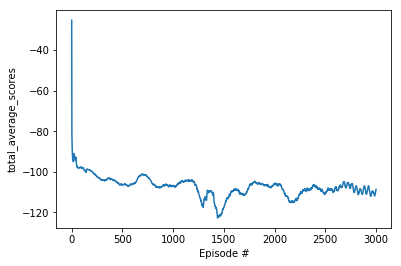

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [36]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)
# print(s.shape)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    a = agent.act(np.reshape(s, [1, -1])) # a: [-1, +1]    # select action (a) from loaded model agent
    #a = agent.act(s)
    #print(s.shape, a.shape)
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    #s2, r, done = env.step(a)
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: -106.75700939138544


When finished, you can close the environment.

In [37]:
env.close()